In [7]:
# generate synthetic handwriting based on a target handwriting
# implementation based on the research from Haines, Aodha, and Brostow 2016.
# https://researchportal.bath.ac.uk/en/publications/my-text-in-your-handwriting

# Author: Rachael Williams
# Last Update: 2/26/23

In [8]:
import pandas as pd
import numpy as np
import cv2
# note about opencv: it uses BGR color format
import imutils
import scipy.cluster
import sklearn.cluster

from google.colab import drive
from google.colab.patches import cv2_imshow

# accessing files from Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [9]:
text_random = '/content/drive/MyDrive/ColabNotebooks/CS98/LinedTextSample_Random.jpg'
# the random text is a ramble of my random thoughts to simulate people's notes
# (still double-spaced to keep it simple for now)

text_fixed = '/content/drive/MyDrive/ColabNotebooks/CS98/LinedTextSample_Frankenstein.jpg'
# the fixed text is an excerpt from Mary Shelley's Frankenstein found on Project Gutenberg
# for automatic glyph tagging, we might want to use a standard text.
# we might want to write one ourself in the spirit of Dreamworld Carnival: https://www.extensis.com/blog/my-quest-to-make-authentic-looking-handwriting-fonts
# or we might want to scrape public domain texts from Project Gutenberg

recs = '/content/drive/MyDrive/ColabNotebooks/CS98/recs.png'
nemo = '/content/drive/MyDrive/ColabNotebooks/CS98/OIP.jpg'

im_random = cv2.imread(text_random)
im_recs = cv2.imread(recs)
im_nemo = cv2.imread(nemo, cv2.COLOR_BGR2RGB)

# display an image
def im_display(im, s=0, colab=False):
    """
    Function to encapsulate the steps to show an image using OpenCV.

    Inputs: 
        - im: image loaded from cv2.imread
        - s: number of milliseconds to display the image
             0 means to keep the image up until the user closes it
        - colab: boolean False if running a .py file, True if using Google Colab
        note: if you are using Jupyter Notebook, this function won't work

    Output:
        - none, no return value
    """
    
    # cv2.imshow causes Google Colab to crash, but cv2_imshow is a patch
    # specficially to be used with the Colab environment
    if colab:
        cv2_imshow(im)
    else:
        cv2.imshow("image display", im)
    
    cv2.waitKey(s)
    cv2.destroyAllWindows()


def im_rescale(im, s):
    h_s = int(im.shape[0] * s)
    w_s = int(im.shape[1] * s)

    rescale = (w_s, h_s)
    new_im = cv2.resize(im, rescale, interpolation= cv2.INTER_LINEAR)

    return new_im

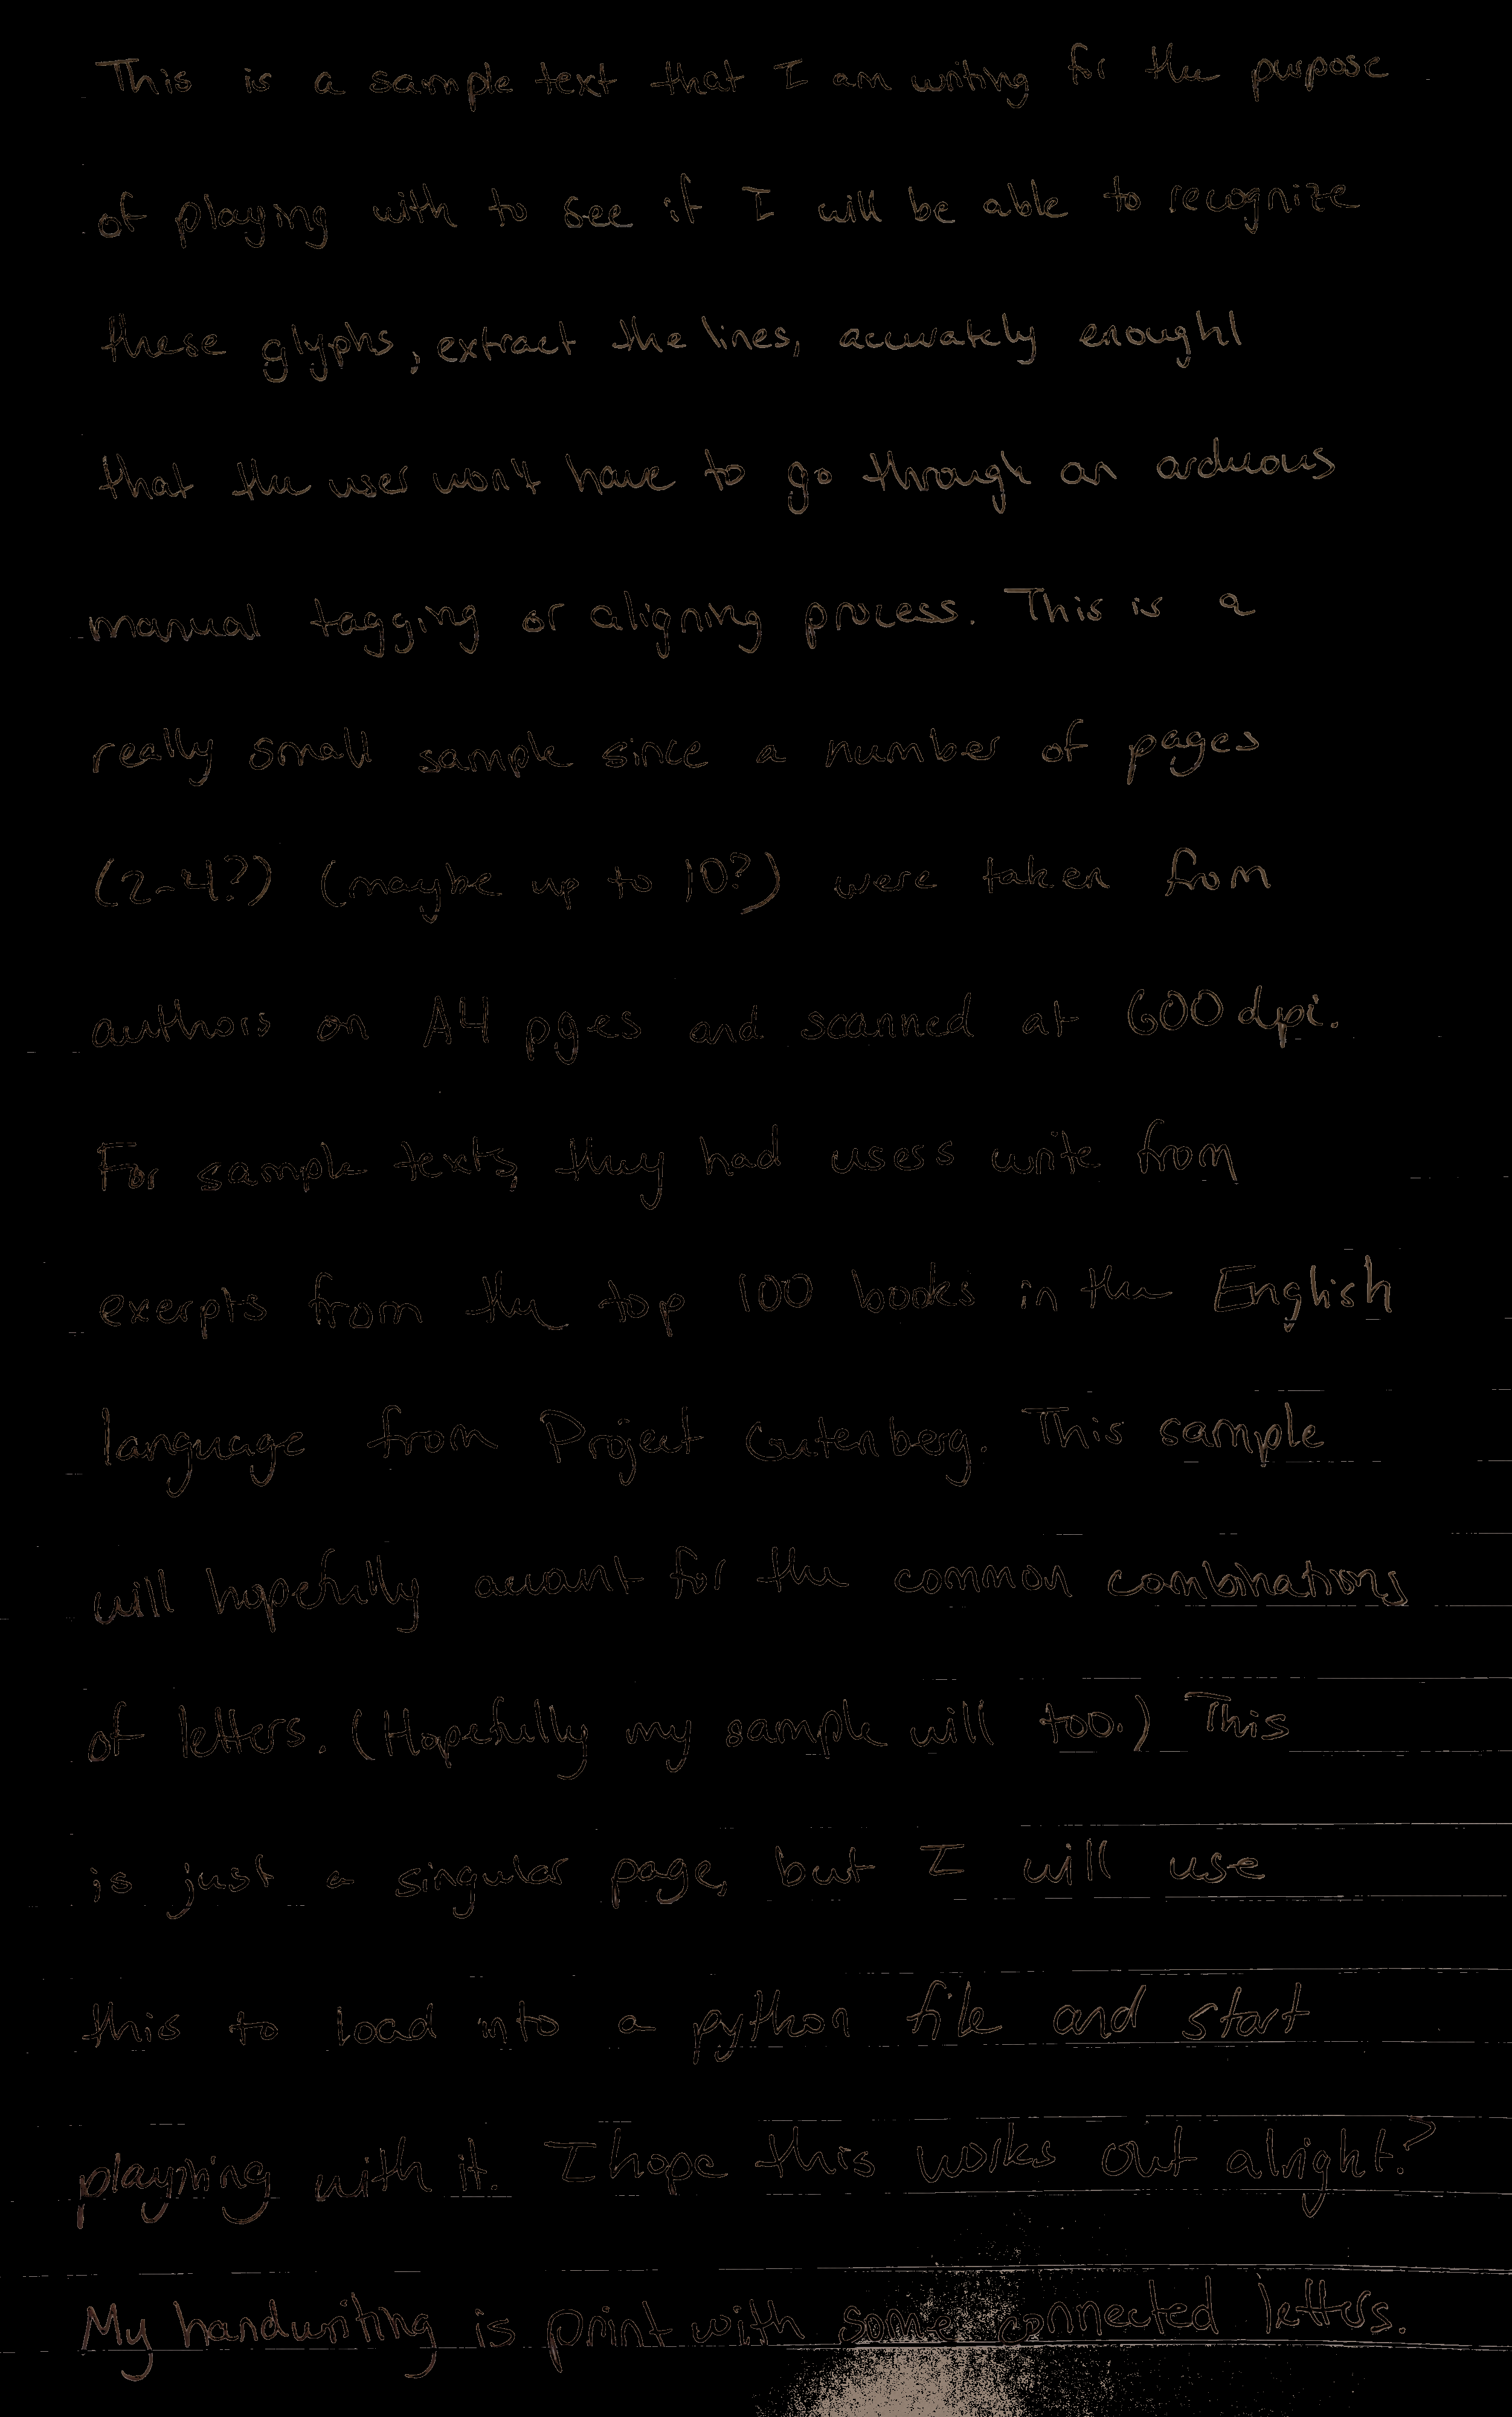

In [10]:
# Strategy 3: Apply a mask (Rachael)
def apply_mask(im, lower, upper, display=False):
    # grayscale the image
    # im_gray = cv2.imread(text_random, 0)  # 0 is the same as cv2.IMREAD_GRAYSCALE

    # convert to HSV
    im_hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

    mask = cv2.inRange(im_hsv, lower, upper)

    # apply the mask
    im_res = cv2.bitwise_and(im, im, mask=mask)

    if display:
        im_display(im_res, colab=True)
    else:
        return im_res


# thesholds on the color green  
lower = np.array([0, 20, 0])
upper = np.array([70, 150, 150])

apply_mask(im_random, lower, upper, display=True)

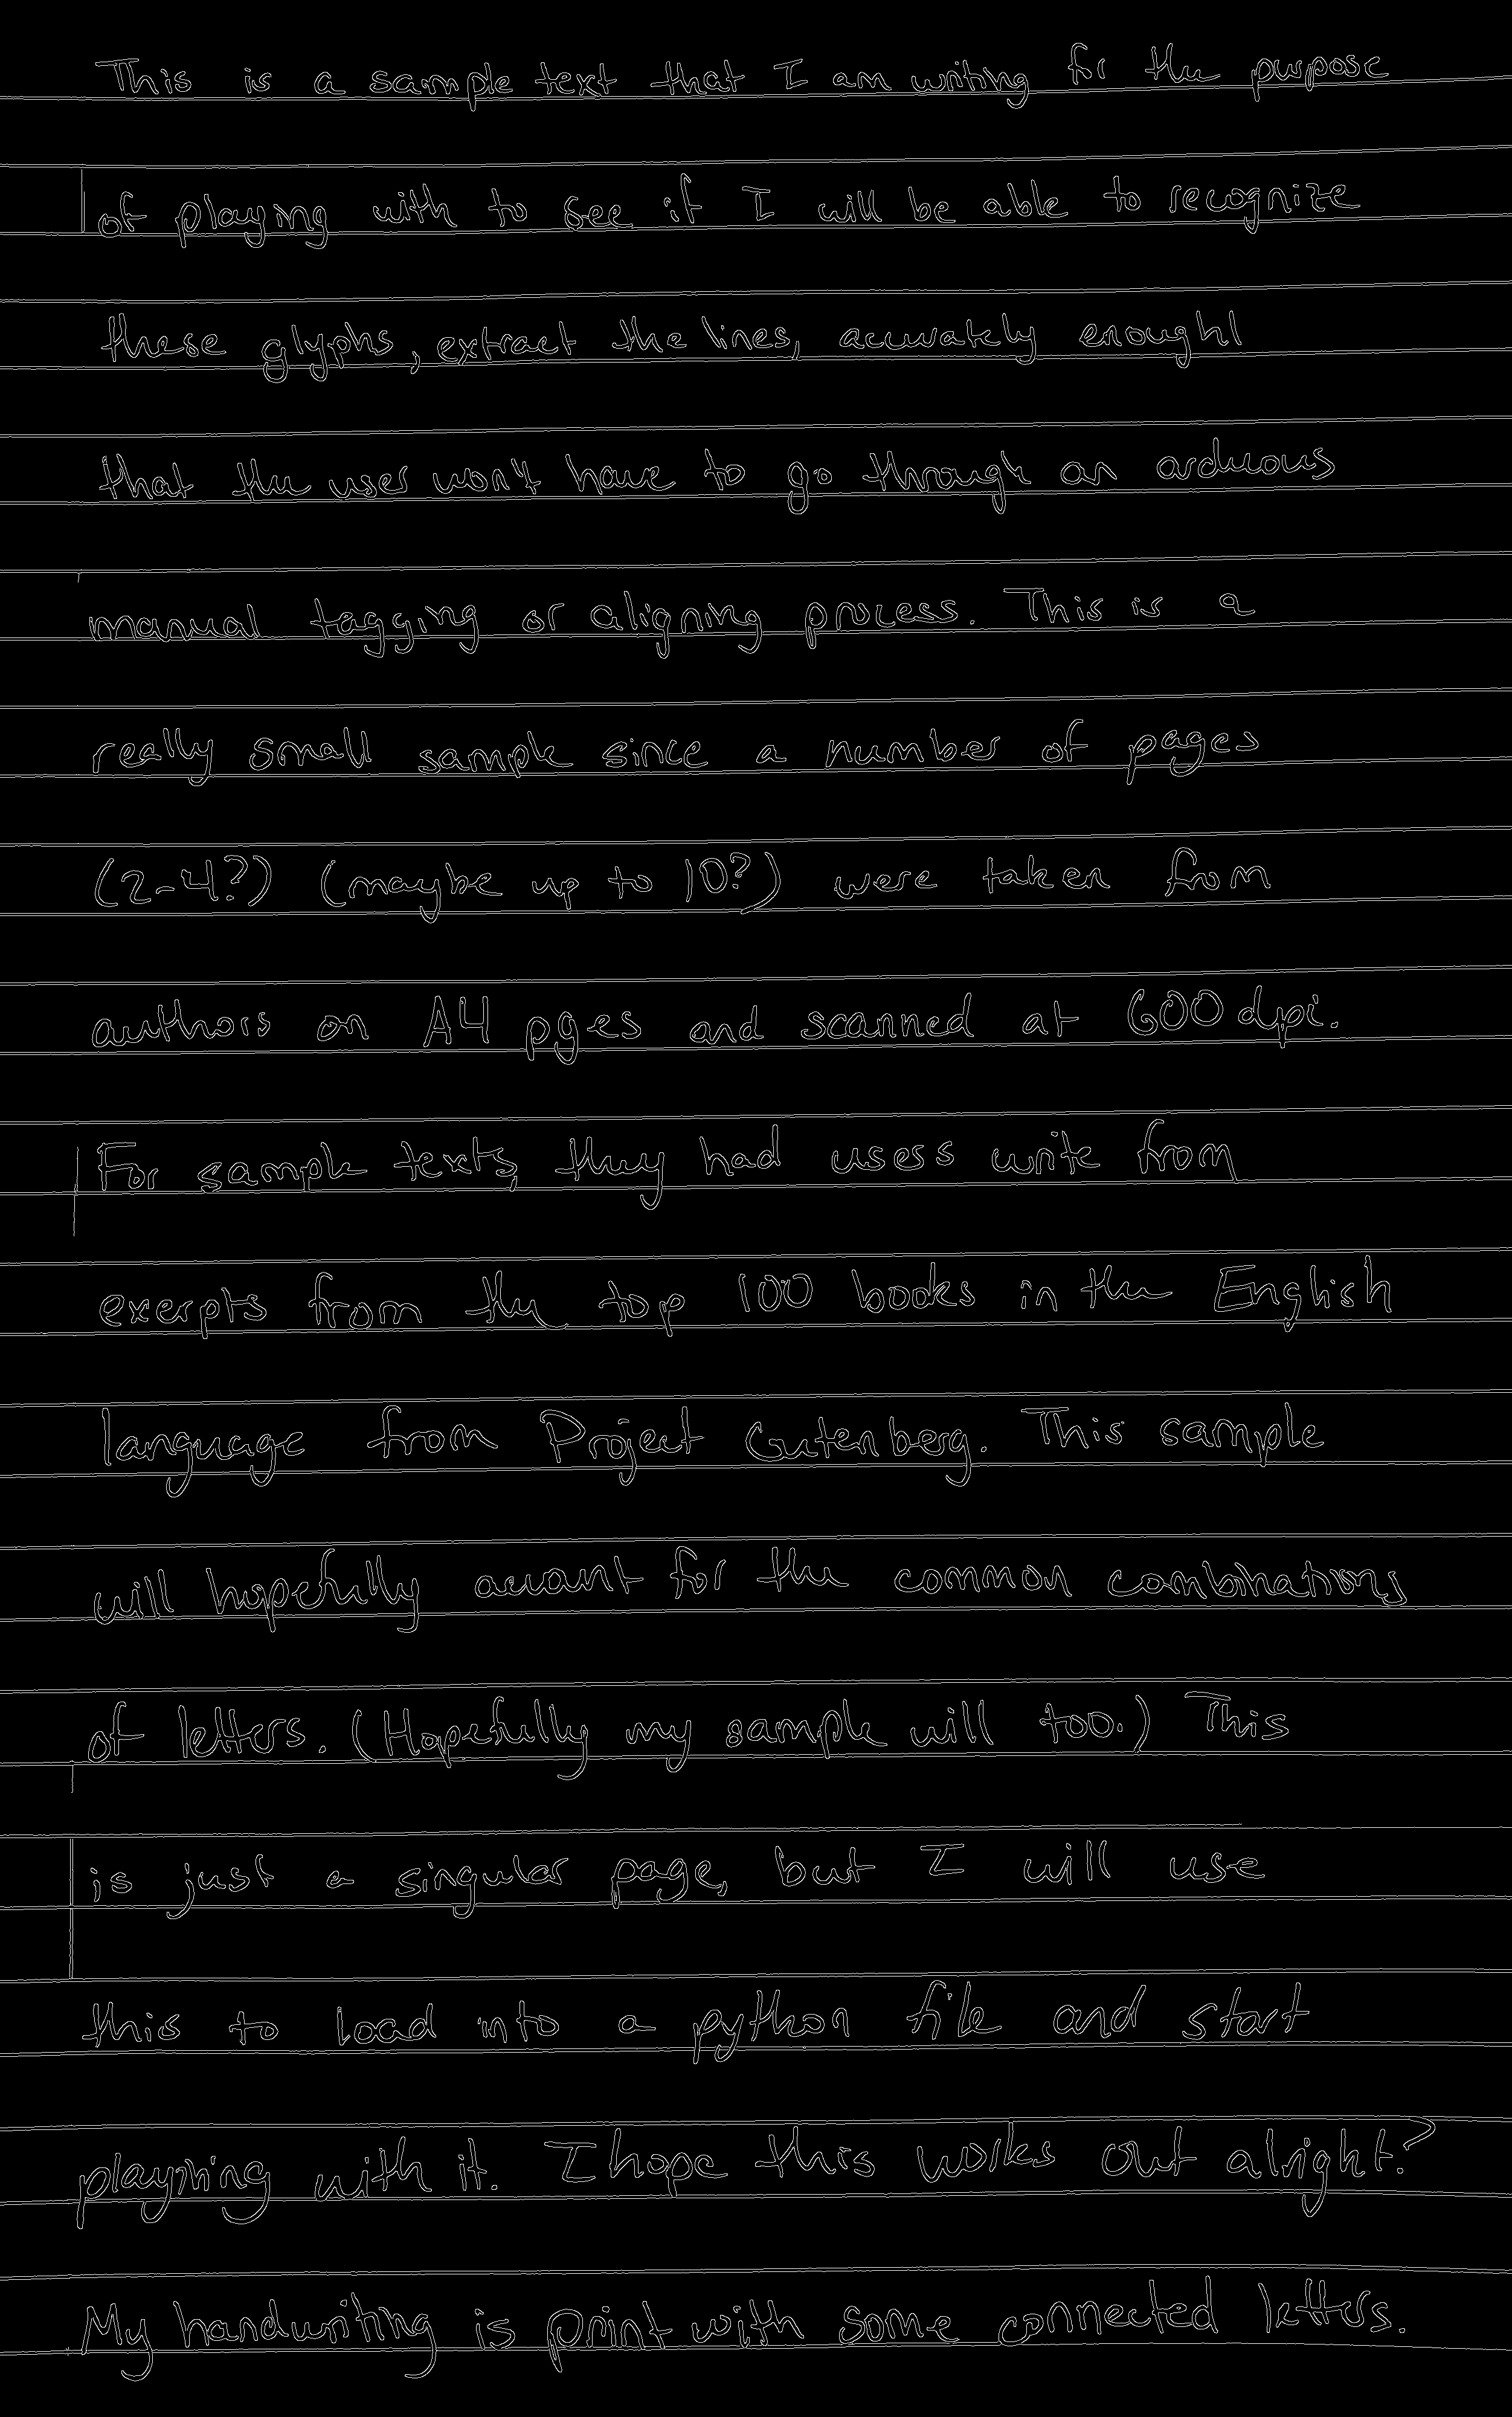

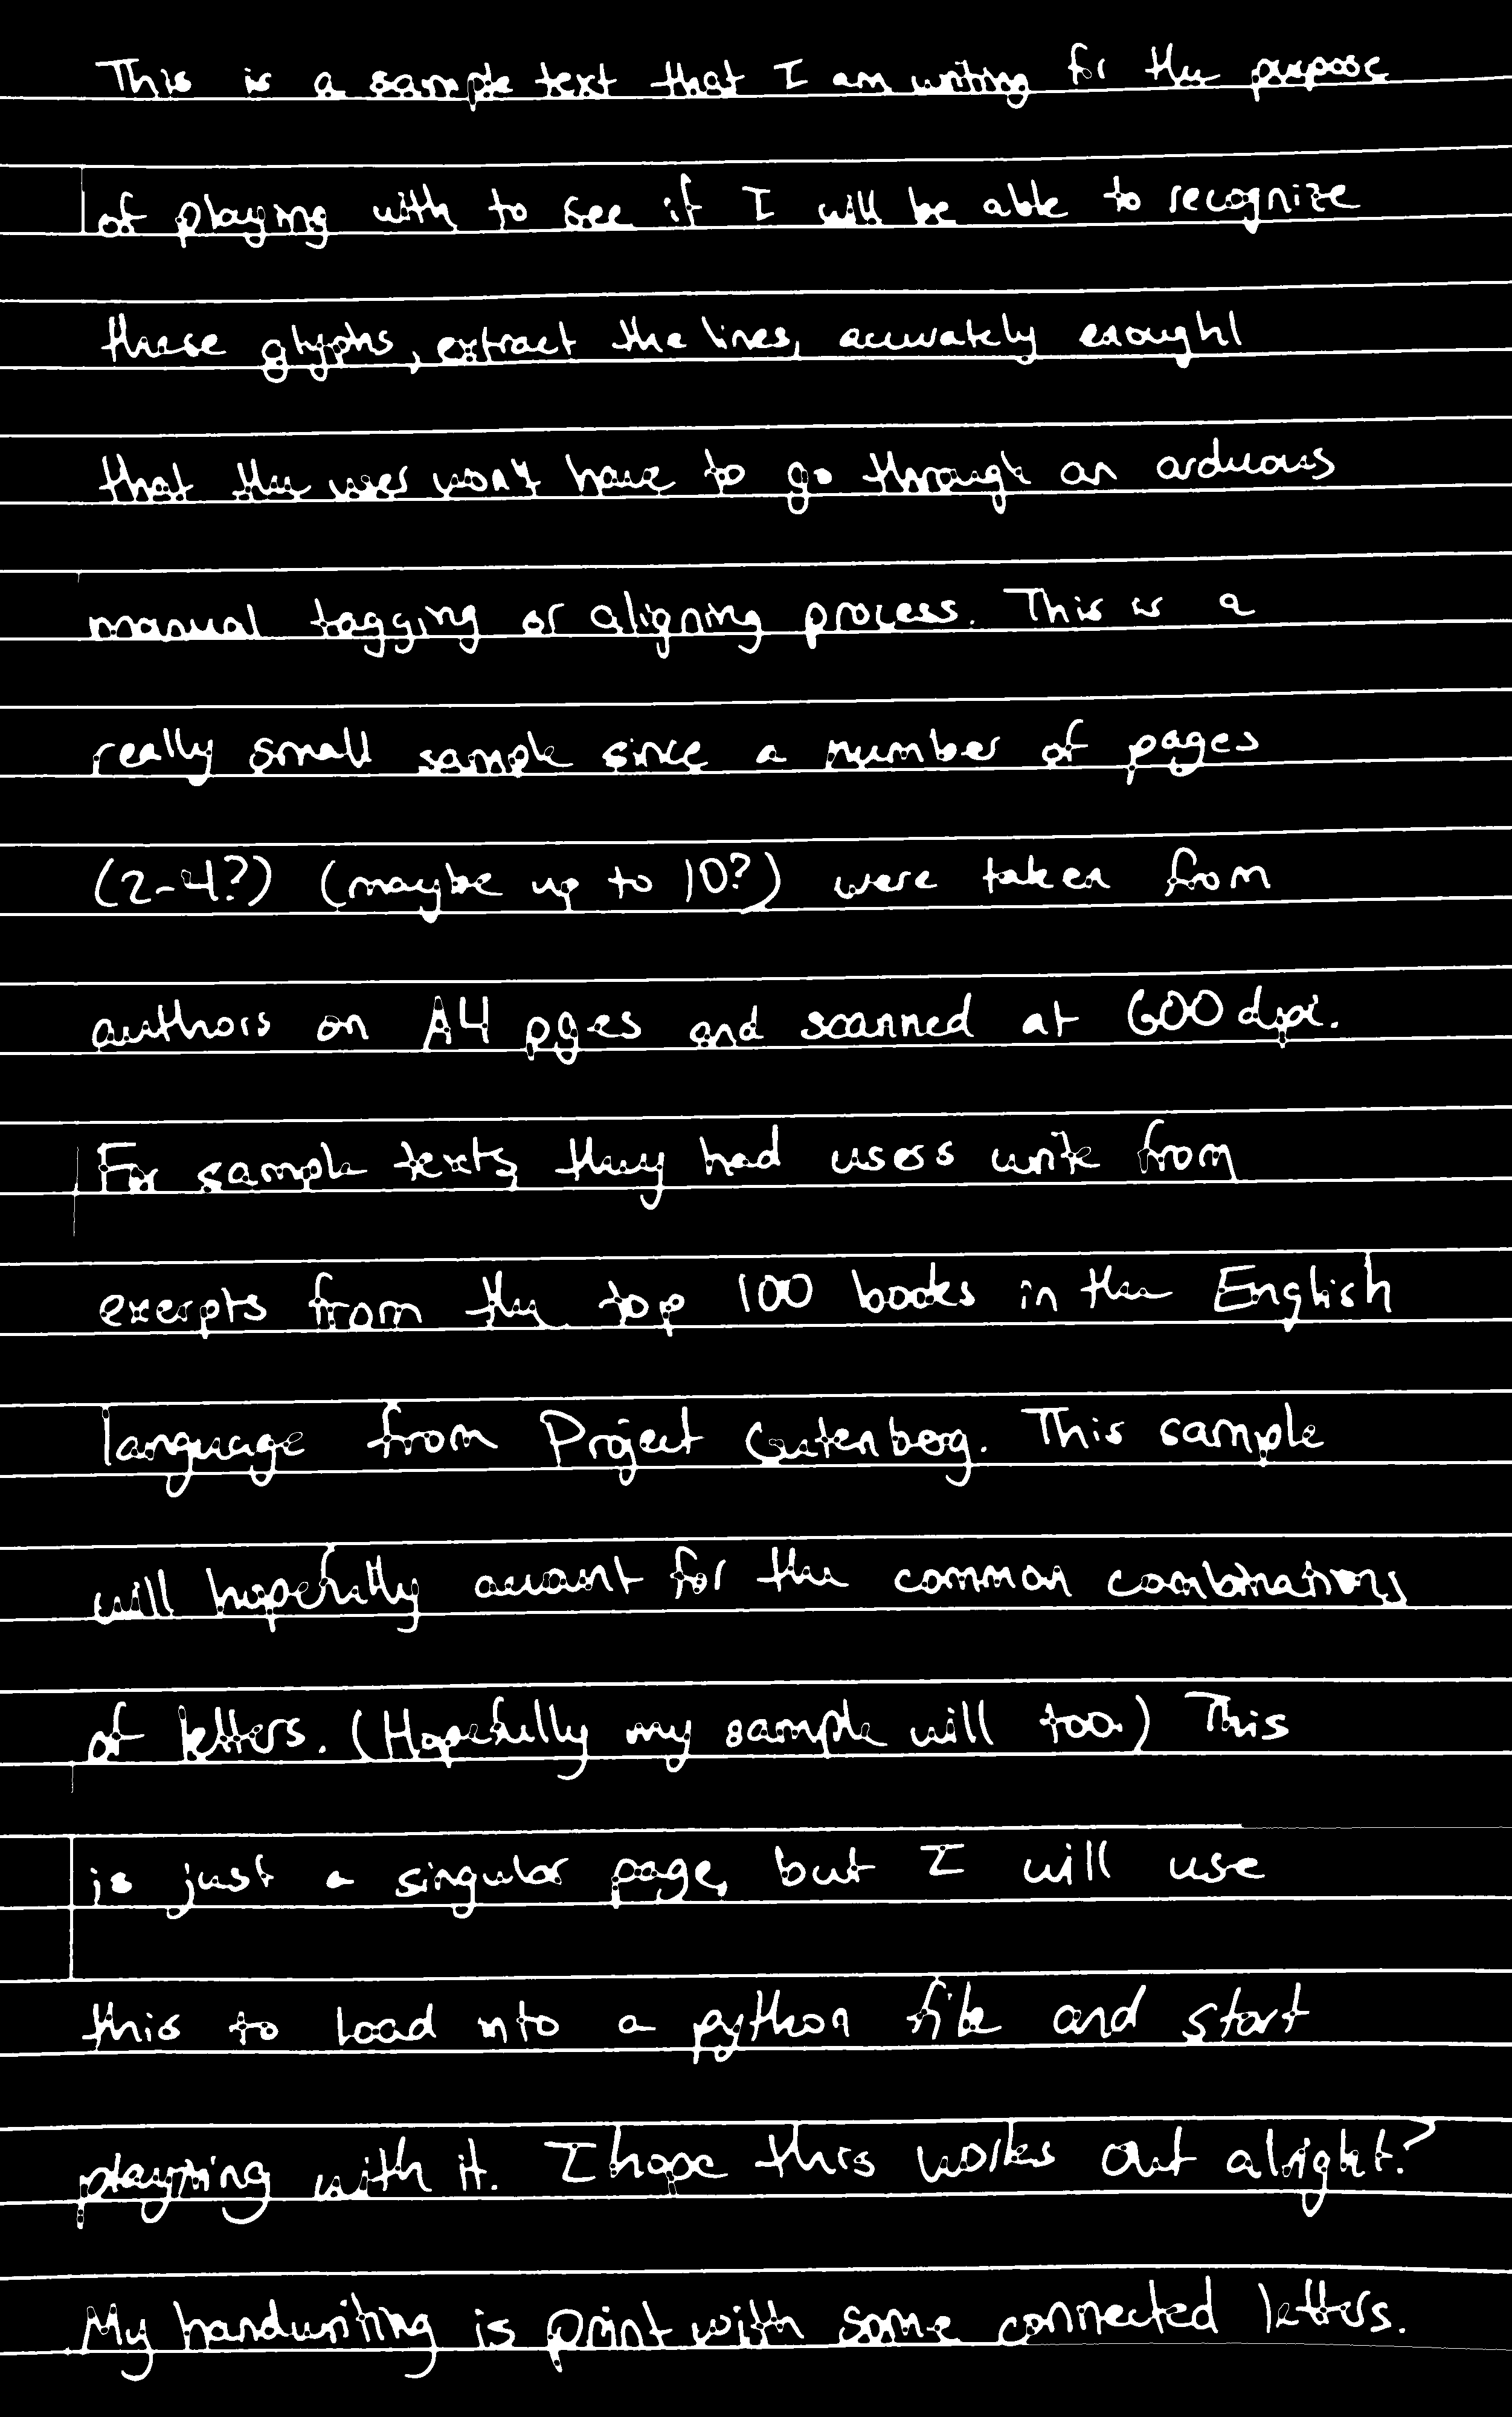

In [11]:
# Strategy 2: Feature Detection (Rachael method)
def detect_edges(im, display=False):
    """
    Function to detect edges in an image.

    Input: image loaded from cv2.imread
    
    Output: edges, an image edge map
    """
    # thesholds on the color green  
    lower = np.array([0, 20, 0])
    upper = np.array([70, 150, 150])
    im_mask = apply_mask(im, lower, upper)

    # grayscale the image
    im_gray = cv2.imread(text_random, 0)  # 0 is the same as cv2.IMREAD_GRAYSCALE

    # perform Gaussian blurring to reduce noise
    im_blur = cv2.GaussianBlur(im_gray, (5, 5), 0)

    # perform edge detection
    edges = cv2.Canny(im_blur, 50, 150, apertureSize=3)


    # fill in the lines lol
    # this is pretty janky with edge detection, so possibly
    # comment this section out
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    dilated = cv2.dilate(edges, kernel)
    eroded = cv2.erode(dilated, kernel)
    
    # handle output
    if display:
        im_display(edges, 0, True)
        im_display(eroded, 0, True)
    else:
        return edges

detect_edges(im_random, display=True)

In [ ]:
# ink extraction

# Strategy 1: Assign Ink Levels to Every Pixel (Haines et. al method)
# assume pixels depict either paper or ink color
# worse option: assume binary color space. Use mean shift with Gaussian kernel to identify the two largest colors in the image
# better option: line ink replacement
# this will allow any writing implements (e.g. pen, pencil, etc.) to be inputted or outputted.
# how to do this:
# pass a line through both modes from the Gaussian kernel
# the paper is treated as 0 and the ink color is treated at strength 1
# the halfway point which marks the boundary between ink and paper is treated as 0 (paper)
# linear interpolation maps every pixel to an ink level

# Strategy 1.5: Assign Ink Levels to Every Pixel (check if pixel is in contour)
def assign_ink_level(im):
    """
    Function to assign ink levels in an image. 
    Assumes that pixels depict either paper color or ink color.

    Desired Output: shading map, np.array the same size as original im
    with every pixel represented by a float between 0 and 1.
    0 is the paper and boundary between paper and ink
    1 is the intensity of the ink color
    """
    im = im_rescale(im, 0.5)  # downsize the image by half

    new_im = np.zeros((im.shape[0], im.shape[1], 1), np.uint8)
    #im_display(new_im, colab=True)

    edges = detect_edges(im)
    cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(cnts) == 2:
        cnts = cnts[0]
    else:
        cnts = cnts[1]
    #print("Number of Contours found = " + str(len(cnts)))
  
    # draw all contours
    # -1 signifies drawing all contours
    #cv2.drawContours(im, cnts, -1, (0, 255, 0), 3)
    #im_display(im, colab=True)

    # check if point is inside contour/shape
    it = np.nditer(im, flags=['multi_index'])
    while not it.finished:
        y, x = it.multi_index[0], it.multi_index[1]

        for c in cnts:
            res = cv2.pointPolygonTest(c, (x,y), False) 

            # inside the contours
            if res == 1:
                new_im[y][x] = 255  # assign this to 1
                # TODO: linear interpolation based on value between paper and ink color
                break
            # outside the countours (res == -1) or on the boundary (res == 0)
            else:
                new_im[y][x] = 0

        it.iternext()

    im_display(new_im, colab=True)

assign_ink_level(im_random)



In [ ]:
# Strategy 1b / 2b: Remove Lines from Paper using Houghline Method, then do Strategy 1 or 2
# https://www.geeksforgeeks.org/line-detection-python-opencv-houghline-method/
# This does NOT work to recognize the lines from notebook paper.
def detect_lines(im):
    edges = detect_edges(im)

    # get the array of r and theta values
    lines = cv2.HoughLines(edges, 1, np.pi/180, 500)

    # run a loop until r and theta values
    # are in the range of the 2d array
    for r_theta in lines:
        arr = np.array(r_theta[0], dtype=np.float64)
        r, theta = arr

        a = np.cos(theta)
        b = np.sin(theta)
    
        x0 = a*r  # rcos(theta)
        y0 = b*r  # rsin(theta)
    
        x1 = int(x0 + 1000*(-b))  # rounded off value of rcos(theta)-1000sin(theta)
        y1 = int(y0 + 1000*(a))  # rounded off value of rsin(theta)+1000cos(theta)
        x2 = int(x0 - 1000*(-b))  # rounded off value of rcos(theta)+1000sin(theta)
        y2 = int(y0 - 1000*(a))  # rounded off value of rsin(theta)-1000cos(theta)
    
        # cv2.line draws a line in img from the point(x1,y1) to (x2,y2).
        # (0, 0, 255) denotes the color of the line to be
        # drawn. In this case, it is red because OpenCV uses BGR format
        cv2.line(im, (x1, y1), (x2, y2), (0, 0, 255), 2)

    im_display(im, colab=True)

detect_lines(im_random)

In [ ]:
# code for dominant colors from: https://stackoverflow.com/a/64600498
def get_dominant_colors(im): 
    image = np.resize(im, (150, 150))  # thumbnail reduces time
    ar = np.asarray(im)
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    kmeans = sklearn.cluster.MiniBatchKMeans(
        n_clusters=10,
        init="k-means++",
        max_iter=20,
        random_state=1000  # makes it deterministic
    ).fit(ar)

    codes = kmeans.cluster_centers_

    vecs, _dist = scipy.cluster.vq.vq(ar, codes)  # assign codes
    counts, _bins = np.histogram(vecs, len(codes))  # count occurrences

    # get colors in order of dominance
    colors = []
    for i in np.argsort(counts)[::-1]:
        colors.append(tuple([int(code) for code in codes[i]]))
    return colors 

get_dominant_colors(im_random)


def get_contrast(im):
    colors = get_dominant_colors(im)

    max = colors[0]
    min = colors[0]

    for c in colors:
        if sum(c) > sum(max):
            max = c
        elif sum(c) < sum(min):
            min = c

    return min, max  # lighter color, darker color

print("res:")
get_contrast(im_random)